# ドローダウンの評価プログラム

## 準備その1: 必要なライブラリの読み込み
下のセルをクリックして，shift-Return を押すか，セルの左に表示される実行ボタンを押してください。

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

import warnings
warnings.filterwarnings('ignore')

# yahoo finance連携用モジュール
#!pip install yfinance
import yfinance as yf

## 準備その2: 株価データやプログラムの読み込み
下のセルをクリックして，shift-Return を押すか，セルの左に表示される実行ボタンを押してください。

In [89]:
def get_data(start, end, codelist):
    data = yf.download(codelist, start, end)
    #  data = yf.download(codelist, start, end)

    #  display(data)
    return data["Adj Close"]


def draw_graph(data, title="", ylabel="", sma=True):

    if not isinstance(data, list):
        data = [data]

    plt.figure(figsize=(8, 4))
    plt.title(title, fontsize=16)

    for d in data:
        plt.plot(d)

        if sma == True:
            for days in [50, 100, 200]:
                sma = d.rolling(days).mean()
                plt.plot(sma)

    plt.ylabel(ylabel, fontsize=14)
    plt.grid()
    plt.show()


def count_drawdown(drawdown):
    df = pd.DataFrame(drawdown.copy())
    df.columns = ["pct"]
    df["drawdown"] = df == 0
    df["drawdown_id"] = df["drawdown"].ne(df["drawdown"].shift()).cumsum()
    res = df.groupby(by="drawdown_id").min()
    for pct in [5, 10, 15, 20]:
        print("Num of {:2}% drawdown: {}".format(pct, (res.pct <= -pct).sum()))


#        display(res[res.pct<=-pct])


def get_drawdown(data, tickers):
    previous_peaks = data.cummax()
    drawdown = (data - previous_peaks) / previous_peaks * 100

    for ticker in tickers:
        draw_graph(
            data=[data[ticker], previous_peaks[ticker]],
            title=ticker,
            ylabel="price [USD]",
        )
        draw_graph(data=drawdown[ticker], title=ticker, ylabel="drawdown [%]")
        count_drawdown(drawdown[ticker])

    return drawdown


def get_pct_prices(data, tickers, levarage=1):
    previous_peaks = data.cummax()
    drawdown = (data - previous_peaks) / previous_peaks * 100

    for ticker in tickers:
        if levarage == 1:
            print("[{}]".format(ticker))
        else:
            print("[{} (Bull {}x)]".format(ticker, levarage))

        price = data[ticker][-1]
        ATH = previous_peaks[ticker][-1]
        print(" {:.1f}%: ${:.2f} (current)".format(-(1 - price / ATH) * 100, price))

        for days in [50, 100, 200]:
            sma = data[ticker].rolling(days).mean()
            print(
                " {:.1f}%: ${:.2f} (SMA{})".format(
                    -(1 - sma[-1] / ATH) * 100, sma[-1], days
                )
            )

        for pct in range(6):
            pct = -5 * pct * levarage
            print("  {:>3}%: ${:,.1f}".format(pct, ATH * (100 + pct) * 0.01))


def get_pct_prices2(data, tickers, levarage=1):
    previous_peaks = data.cummax()
    drawdown = (data - previous_peaks) / previous_peaks * 100

    for ticker in tickers:
        if levarage == 1:
            print("[{}]".format(ticker))
        else:
            print("[{} (Bull {}x)]".format(ticker, levarage))

        df = pd.DataFrame()
        price = data[ticker][-1]
        ATH = previous_peaks[ticker][-1]

        df = df.append(
            {"pct": -(1 - price / ATH) * 100, "price": price, "remark": "<Current>"},
            ignore_index=True,
        )
        df = df.append({"pct": 0, "price": ATH, "remark": "ATH"}, ignore_index=True)

        for days in [50, 100, 200, 300]:
            sma = data[ticker].rolling(days).mean()
            df = df.append(
                {
                    "pct": -(1 - sma[-1] / ATH) * 100,
                    "price": sma[-1],
                    "remark": "SMA{}".format(days),
                },
                ignore_index=True,
            )

        for pct in range(1,5):
            pct = -5 * pct * levarage
            df = df.append(
                {"pct": pct, "price": ATH * (100 + pct) * 0.01, "remark": "[{:4d}%]".format(pct)},
                ignore_index=True,
            )

        df=df.sort_values('pct',ascending=False)
        format_mapping = {"pct": "{:.1f}%", "price": " ${:,.1f}", "remark": " {}"}
        for key, value in format_mapping.items():
            df[key] = df[key].apply(value.format)
        print(df.to_string(index=False))


get_pct_prices2(data, ["^DJI"])

[^DJI]
   pct      price     remark
  0.0%  $36,799.6        ATH
 -2.4%  $35,911.8  <Current>
 -2.6%  $35,834.0      SMA50
 -3.8%  $35,412.8     SMA100
 -5.0%  $34,959.7    [  -5%]
 -5.1%  $34,935.5     SMA200
 -8.7%  $33,599.8     SMA300
-10.0%  $33,119.7    [ -10%]
-15.0%  $31,279.7    [ -15%]
-20.0%  $29,439.7    [ -20%]


In [53]:
start = datetime.date(1990, 1, 1)
end = datetime.date.today()
tickers = ["^GSPC", "SPXL", "QQQ", "TQQQ","TECL","^DJI","^NDX"]

data=get_data(start, end, tickers)

[*********************100%***********************]  7 of 7 completed


In [87]:
get_pct_prices2(data, ["^DJI"])
get_pct_prices2(data, ["^GSPC"])
get_pct_prices2(data, ["SPXL"], levarage=3)
get_pct_prices2(data, ["^NDX"])
get_pct_prices2(data, ["QQQ"])
get_pct_prices2(data, ["TQQQ"], levarage=3)
get_pct_prices2(data, ["TECL"], levarage=3)

[^DJI]
   pct      price     remark
  0.0%  $36,799.6        ATH
 -2.4%  $35,911.8  <Current>
 -2.6%  $35,834.0      SMA50
 -3.8%  $35,412.8     SMA100
 -5.0%  $34,959.7    [  -5%]
 -5.1%  $34,935.5     SMA200
 -8.7%  $33,599.8     SMA300
-10.0%  $33,119.7    [ -10%]
-15.0%  $31,279.7    [ -15%]
-20.0%  $29,439.7    [ -20%]
[^GSPC]
   pct     price     remark
  0.0%  $4,796.6        ATH
 -2.4%  $4,681.0      SMA50
 -2.8%  $4,662.9  <Current>
 -4.6%  $4,575.1     SMA100
 -5.0%  $4,556.7    [  -5%]
 -7.8%  $4,420.8     SMA200
-10.0%  $4,316.9    [ -10%]
-12.3%  $4,208.8     SMA300
-15.0%  $4,077.1    [ -15%]
-20.0%  $3,837.2    [ -20%]
[SPXL (Bull 3x)]
   pct   price     remark
  0.0%  $145.9        ATH
 -6.6%  $136.3      SMA50
 -8.2%  $133.9  <Current>
-12.4%  $127.9     SMA100
-15.0%  $124.1    [ -15%]
-20.4%  $116.2     SMA200
-30.0%  $102.2    [ -30%]
-30.0%  $102.1     SMA300
-45.0%   $80.3    [ -45%]
-60.0%   $58.4    [ -60%]
[^NDX]
   pct      price     remark
  0.0%  $16,573.3  

#### ドローダウンの大きさ

右下のコーナーに**解析期間を入力**し，その後，下のセルをクリックして，shift-Return を押すか，セルの左に表示される実行ボタンを押してください。

**注意**
- **開始年月は1993年以降**にしてください。(SPYは1993年以降，QQQは1999年以降しかデータがありません)
- **5%以上のドローダウンの回数には，10%以上の下げも含みます**
- 日々の値動きは，Closeのタイミングで評価しています。


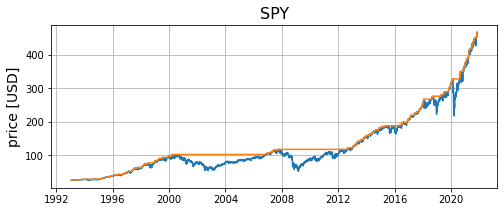

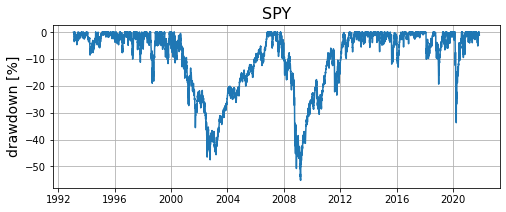

Num of  5% drawdown: 30
Num of 10% drawdown: 10
Num of 15% drawdown: 5
Num of 20% drawdown: 3
Num of 30% drawdown: 3
Num of 40% drawdown: 2
Num of 50% drawdown: 1


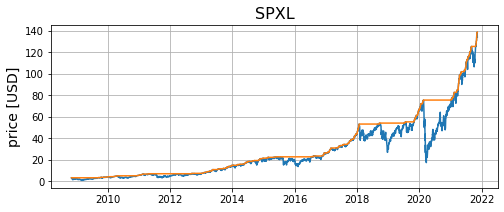

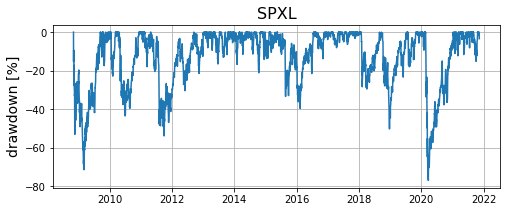

Num of  5% drawdown: 44
Num of 10% drawdown: 28
Num of 15% drawdown: 16
Num of 20% drawdown: 10
Num of 30% drawdown: 6
Num of 40% drawdown: 5
Num of 50% drawdown: 4


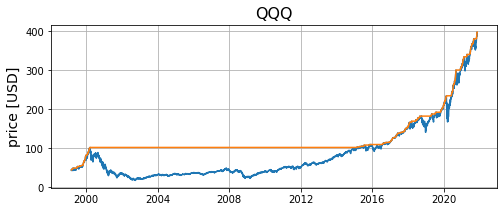

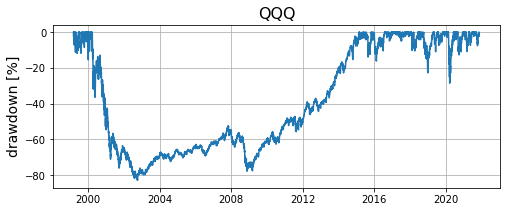

Num of  5% drawdown: 23
Num of 10% drawdown: 16
Num of 15% drawdown: 5
Num of 20% drawdown: 3
Num of 30% drawdown: 1
Num of 40% drawdown: 1
Num of 50% drawdown: 1


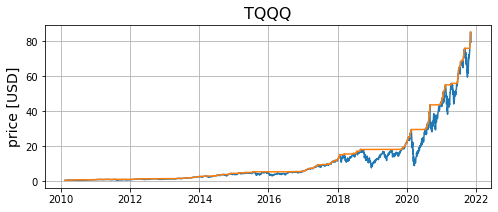

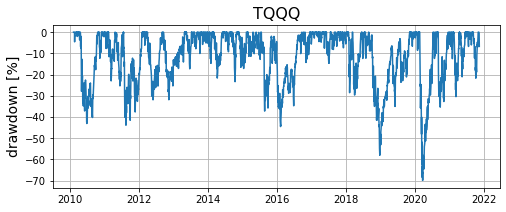

Num of  5% drawdown: 55
Num of 10% drawdown: 31
Num of 15% drawdown: 19
Num of 20% drawdown: 17
Num of 30% drawdown: 9
Num of 40% drawdown: 5
Num of 50% drawdown: 2


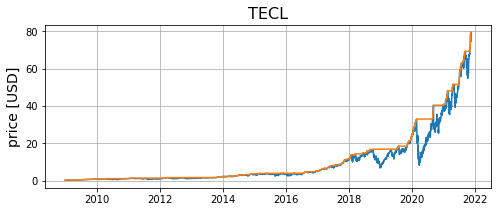

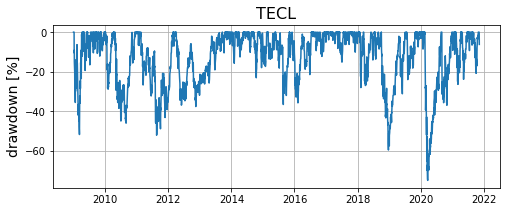

Num of  5% drawdown: 63
Num of 10% drawdown: 35
Num of 15% drawdown: 22
Num of 20% drawdown: 17
Num of 30% drawdown: 9
Num of 40% drawdown: 5
Num of 50% drawdown: 4


In [70]:
start_date = '1993-01-01' #@param {type:"date"}
end_date = '2021-11-10' #@param {type:"date"}

dd=get_drawdown(data[start_date:end_date],tickers=tickers)